# Invasion Percolation with [OpenPNM](http://openpnm.org/) and [Porespy](http://porespy.org/)

In this tutorial we are going to use a couple of open source packages that I have been co-developing throughout my academic career for the analysis of flow in porous materials.

OpenPNM is a simulation package that uses concepts from graph theory to represent the pore-space (by which I mean voids within a solid material that could be filled with gas or liquid) as a connected network. We refer to these discrete spaces as pores and the connections between them as throats. In graph theory you may come across the terminology as nodes and edges or perhaps sites and bonds or maybe even vertices and trusses if dealing with solid mechanics. 

We can actually represent both the pore-space and the solid-space around it with multiple interconncected networks. This technique can generalize to an arbitrary number of phases so for example the battery electrode network made below has the solid network represented in white which is formed from a carbon and active particle phase. And the multicoloured pores represent the electrolyte with ions flowing through it. Multiple different physical scenarios can be modelled such as ion transport using Ohm's law, Diffusion using Fick's law or Heat conduction using Fourier's law. These are all analogous in a way and can be formulated as a linear transport process and solve with linear algebra techniques that are well suited to scipy and other python based solvers.

![Imgur](https://imgur.com/KO9WuV8.png)

In addition to linear transport pore network models are very useful for solving percolation problems which are not so relevant to batteries but occur within other electrochemical devices and porous materials such as Fuel Cells. Percolation is the process whereby two fluids (usually gas and liquid but can be two liquids) both occupy the pore space and differences in pressure control which fluid moves in which direction. This is known as capillary transport and the capillary pressure at the interface between the two fluids is a function of their surface tension, the size of the interface and the contact angle with the solid. A simple equation to calculate capillary pressure is the Yound-Laplace equation:
$ P_c = \frac{2 \sigma cos(\theta)}{r_c} $

![](https://upload.wikimedia.org/wikipedia/commons/4/43/CapillaryRise.png)

Here water is wetting as the contact angle is less than 90 degrees when measured through the water phase and therefore the pressure difference induced by the capillary forces mean it will creep up the capillary tube until equilibrium is reached as gravity acts against them. Within porous materials we can neglect gravity to a certain extent and look at the sizes of throats connecting neighboring pores. In a fuel cell the air is the wetting phase and water is non-wetting so the pressure in the water phase must be increased to overcome the capillary forces for water to push into pores and this is mostly dominated by the sizes of the throats connecting pores. We can think of our pore network being formed of many small capillary tubes.

Invasion percolation is a step by step process where the water is assumed to be connected to an external source or reservoir in which the pressure can be controlled. The water makes contact with the edge of the network at a boundary face and the pressure is common to all the boundary pores. As pressure increases the throat with the lowest capillary pressure threshold is invaded and the liquid phase moves into the connecting pore. Now all the neighbors of the newly invaded pore are now accessible and their entry pressures are also added to the analysis. The process repeats always selecting the path of least capillary pressure until the whole network is invaded. More details can be found in [Wilkinson and Willemson](http://www.physics.purdue.edu/flow/MMproject/Wilkinson1983.pdf)

In [62]:
import sys
import openpnm as op
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
import porespy as ps
from ipywidgets import interact, IntSlider
from openpnm.topotools import trim
import ipywidgets as widgets
%matplotlib notebook
ws = op.Workspace()
ws.settings["loglevel"] = 40

In order to also showcase some other network generation options we first start with a small 2D network with ``StickAndBall`` geometry.

In [3]:
spacing=2.5e-5
net = op.network.Cubic([20, 20, 1], spacing=spacing)
geo = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2022-02-09 09:32:54,432
------------------------------------------------------------


We then trim all the surface pores to obtain disctint sets of boundary edge pores.

In [4]:
net.labels()
net.num_throats('surface')
trim(network=net, throats=net.throats('surface'))
h = net.check_network_health()
trim(network=net, pores=h['trim_pores'])

Then we use a function from our porespy package to generate a tomography style image of the abstract network providing the number of pixels in each dimension. Porespy has some very cool image analysis methods and also network extraction tools which can be used on tomography data such as the redox flow battery electrode below which was gathered during some of our [recent work](https://doi.org/10.1016/j.ces.2018.10.049).

![Imgur](https://imgur.com/Jq2DFZm.png)

In [5]:
#NBVAL_IGNORE_OUTPUT
im = ps.io.openpnm_to_im(net, max_dim=1000)

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/684 [00:00<?, ?it/s]

In [6]:
im.shape

(1000, 1000, 50)

This creates a 3D image but we can crop it to get the central slice in 2D for visualization.

<IPython.core.display.Javascript object>


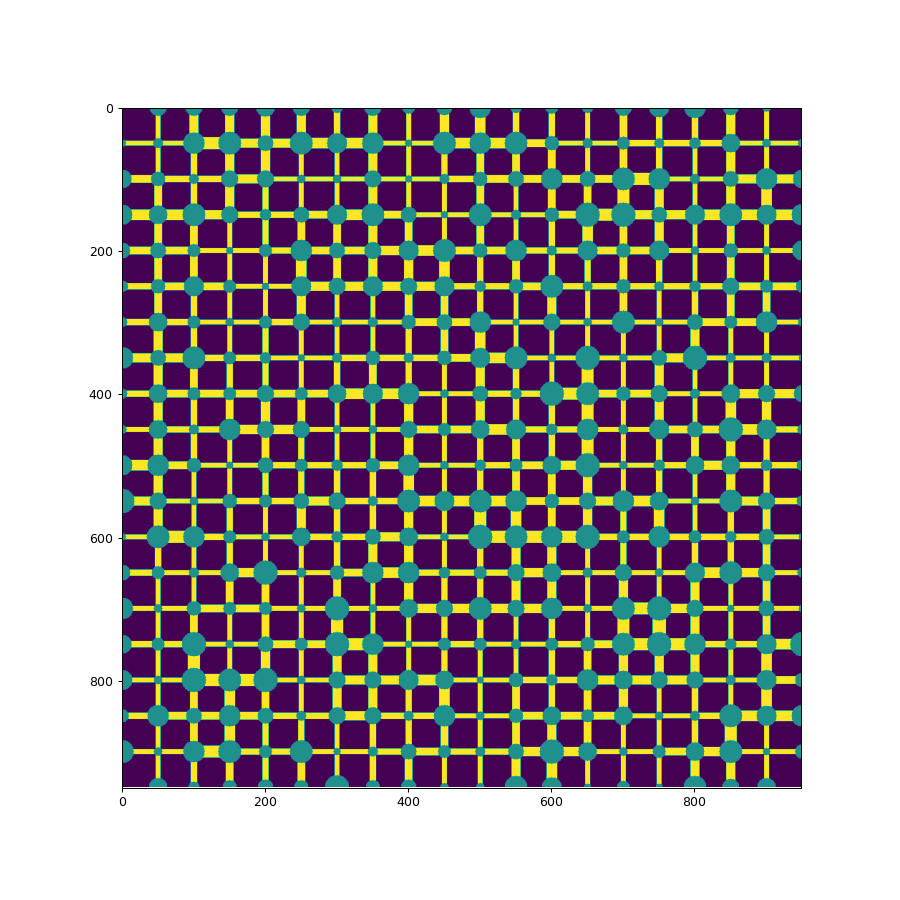

In [7]:
#NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(im[25:-25, 25:-25, 25].T)
crop = im[25:-25, 25:-25, :]

We can also save this image and have a look at it which other packages such as imageJ

In [8]:
from skimage.io import imsave
imout = crop.copy()
imout[imout == 1] = 125
imout[imout == 2] = 255
imsave('test_network.tiff', imout)

Next the snow algorithm is used to do network extraction on the tomography style image. Of course if you have your own tomogrpahy image this can be used instead.

In [10]:
#NBVAL_IGNORE_OUTPUT
snow_out = ps.networks.snow2(crop > 0, voxel_size=4e-7)

Extracting pore and throat properties:   0%|          | 0/491 [00:00<?, ?it/s]

In [11]:
snow_out.regions.shape

(956, 956, 56)

The SNOW algorithm provides a labelled region image containing the pore index. As zero is used for the background it is actually the pore index + 1 because python references arrays with first element as zero and we do not explicitly store the pore index.

<IPython.core.display.Javascript object>


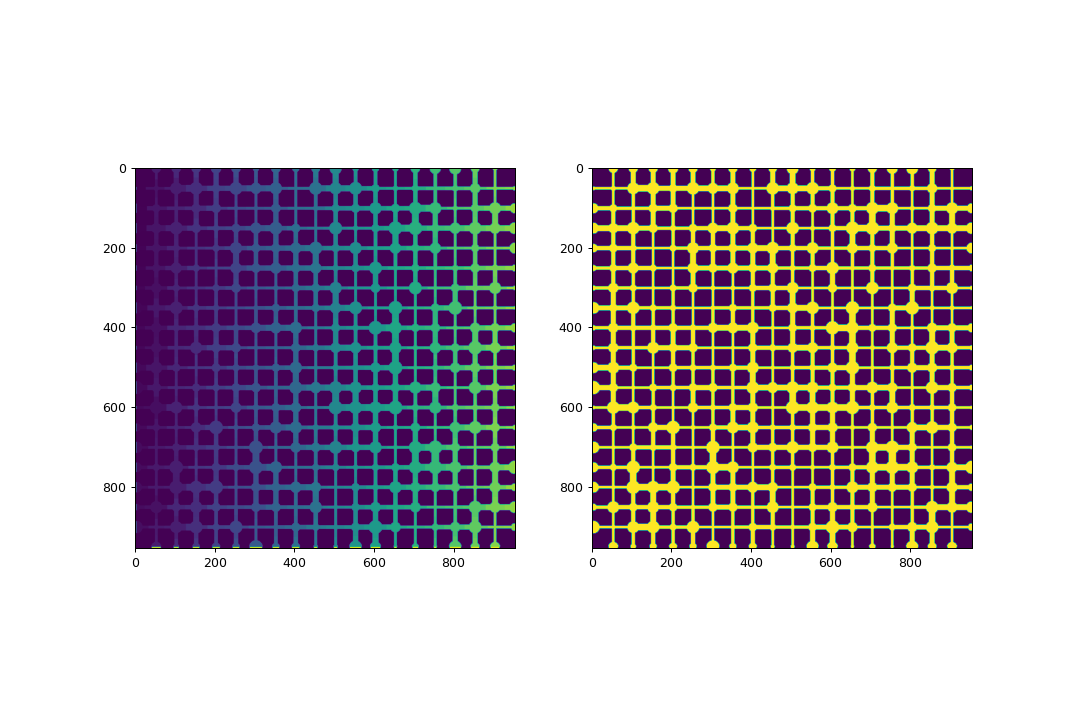

In [37]:
#NBVAL_IGNORE_OUTPUT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
reg = snow_out.regions.astype(float) - 1
reg[reg == -1] = np.nan
region_slice = snow_out.regions[:, :, 28] - 1
mask = region_slice >= 0
ax1.imshow(region_slice.T)
ax2.imshow(mask.T)

Now our new network is extracted we can fill a network object with all the properties and begin simulation.

In [15]:
wrk = op.Workspace()
wrk.clear()

In [21]:
net = op.network.GenericNetwork()
net.update(snow_out.network)
geo = op.geometry.GenericGeometry(network=net, pores=net.Ps, throats=net.Ts)

A helper function is defined for plotting a particular data set.

In [29]:
def update_image(data):
    data = data.astype(float)
    out_im = np.ones(region_slice.shape, dtype=float)*-1
    out_im[mask] = data[region_slice[mask]]
    out_im[~mask] = np.nan
    return out_im

In [34]:
net.labels()

['pore.all', 'pore.boundary', 'pore.geo_01', 'pore.xmax', 'pore.xmin', 'pore.ymax', 'pore.ymin', 'pore.zmax', 'pore.zmin', 'throat.all', 'throat.geo_01']

In [42]:
net.props()

['pore.coords', 'pore.equivalent_diameter', 'pore.extended_diameter', 'pore.geometric_centroid', 'pore.global_peak', 'pore.inscribed_diameter', 'pore.local_peak', 'pore.phase', 'pore.region_label', 'pore.region_volume', 'pore.surface_area', 'pore.volume', 'throat.conns', 'throat.cross_sectional_area', 'throat.direct_length', 'throat.equivalent_diameter', 'throat.global_peak', 'throat.inscribed_diameter', 'throat.perimeter', 'throat.phases', 'throat.total_length']

In [53]:
net['pore.diameter'] = net['pore.equivalent_diameter']
net['pore.area'] = np.pi * (net['pore.diameter']/2)**2
net['throat.diameter'] = net['throat.equivalent_diameter']
net['throat.area'] = np.pi * (net['throat.diameter']/2)**2

<IPython.core.display.Javascript object>


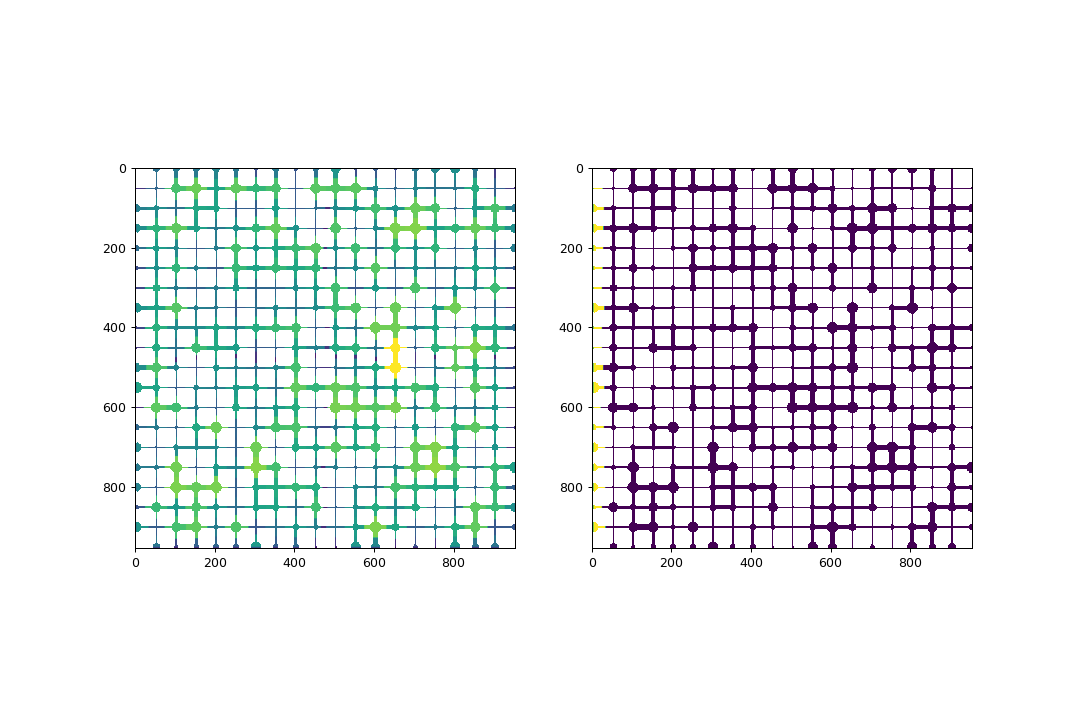

In [54]:
#NBVAL_IGNORE_OUTPUT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
im_diam = update_image(net['pore.diameter'])
left_neighbors = net.find_neighbor_pores(pores=net.pores('xmin'))
data = np.zeros(net.Np)
data[left_neighbors] = 1.0
im_left = update_image(data)
ax1.imshow(im_diam.T)
ax2.imshow(im_left.T)

Again, standard physics is used to define the capillary entry pressures. And these are shown as a histogram for all the throats in the network.

In [55]:
water = op.phases.Water(network=net)
phys = op.physics.Standard(network=net, geometry=geo, phase=water)
print(phys.models)

------------------------------------------------------------
ERROR      : throat.flow_shape_factors was not run since the following property is
             missing: 'throat.conduit_lengths.pore1' 
SOURCE     : openpnm.core.ModelsMixin._regen 
TIME STAMP : 2022-02-09 09:46:00,958
------------------------------------------------------------
------------------------------------------------------------
ERROR      : throat.hydraulic_conductance was not run since the following property is
             missing: 'throat.conduit_lengths.pore1' 
SOURCE     : openpnm.core.ModelsMixin._regen 
TIME STAMP : 2022-02-09 09:46:00,961
------------------------------------------------------------
------------------------------------------------------------
ERROR      : throat.poisson_shape_factors was not run since the following property is
             missing: 'throat.conduit_lengths.pore1' 
SOURCE     : openpnm.core.ModelsMixin._regen 
TIME STAMP : 2022-02-09 09:46:00,963
-----------------------------

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#   Property Name                       Parameter                 Value
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1   throat.flow_shape_factors           model:                    conical_frustum_and_stick
                                        pore_area:                pore.area
                                        throat_area:              throat.area
                                        pore_diameter:            pore.diameter
                                        throat_diameter:          throat.diameter
                                        conduit_lengths:          throat.conduit_lengths
                                        regeneration mode:        deferred
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2   throat.hydraulic_conductance        model:                    hagen_poiseuille
               

In [40]:
? op.models.physics.capillary_pressure.washburn

<IPython.core.display.Javascript object>


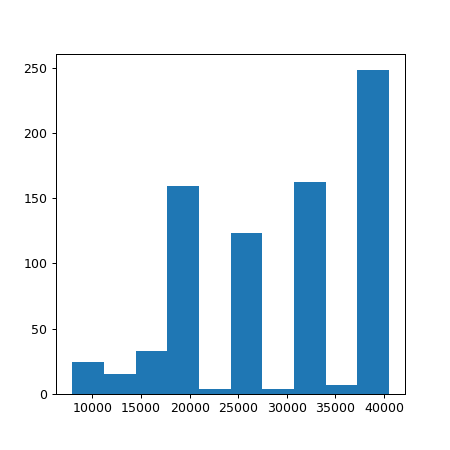

(array([ 24.,  15.,  33., 159.,   4., 123.,   4., 162.,   7., 248.]),
 array([ 7910.58534821, 11171.83017626, 14433.0750043 , 17694.31983235,
        20955.56466039, 24216.80948844, 27478.05431648, 30739.29914452,
        34000.54397257, 37261.78880061, 40523.03362866]),
 <BarContainer object of 10 artists>)

In [56]:
#NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=[5, 5])
ax.hist(phys['throat.entry_pressure'], bins=10)

Next, the algorithm is defined and run with no arguments or outlets defined. This will proceed step by step assessing which pores are currently invaded (i.e. inlets first), which throats connect to an uninvaded pore and of these, which throat has the lowest capillary entry pressure for invasion. Invasion then proceeds along the path of least capillary resistance.

<IPython.core.display.Javascript object>


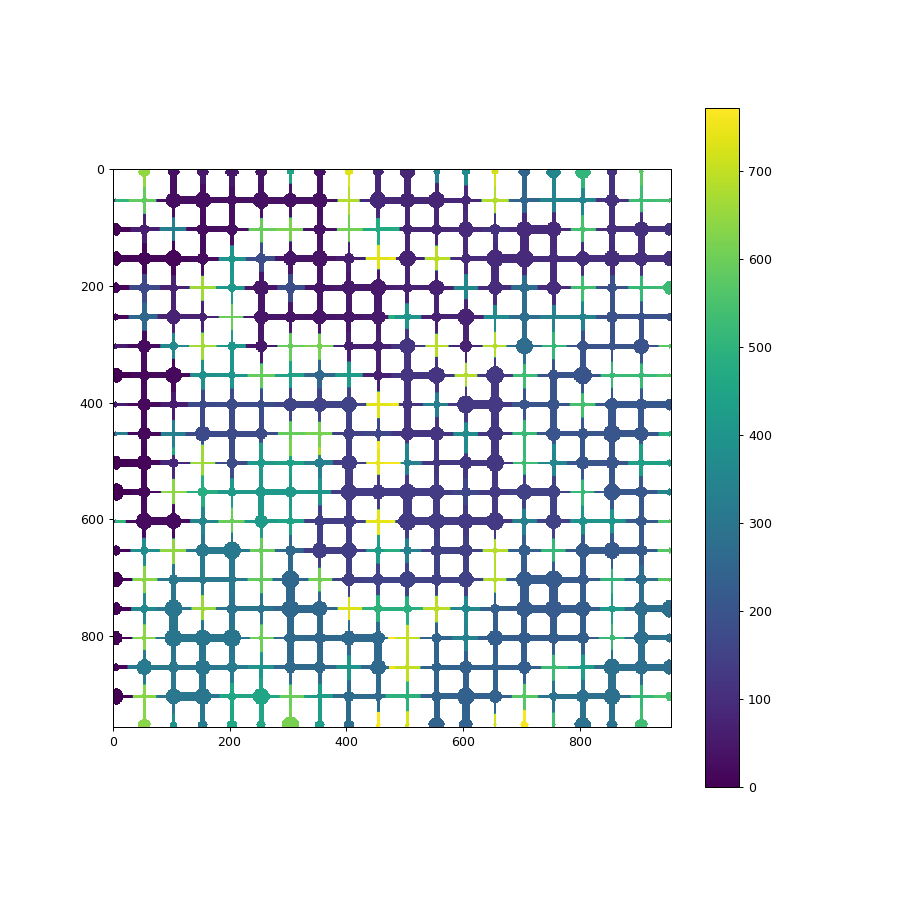

In [58]:
#NBVAL_IGNORE_OUTPUT
alg_ip = op.algorithms.InvasionPercolation(network=net)
alg_ip.setup(phase=water)
alg_ip.set_inlets(pores=net.pores('left'))
alg_ip.run()
fig, ax = plt.subplots(figsize=(10, 10))
out = update_image(alg_ip['pore.invasion_sequence'])
plt.imshow(out.T);
plt.colorbar()

<IPython.core.display.Javascript object>


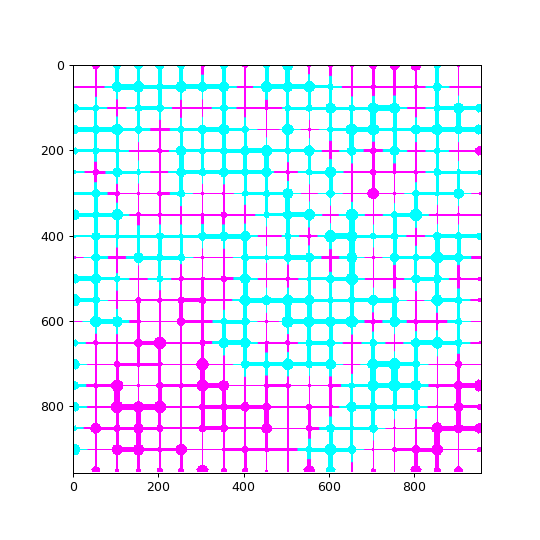

interactive(children=(IntSlider(value=0, description='seq', max=771), Checkbox(value=False, description='inver…

<function __main__.plot_invasion(seq, invert=False)>

In [69]:
fig, ax = plt.subplots(figsize=(6, 6))
max_seq = alg_ip['pore.invasion_sequence'].max()
def plot_invasion(seq, invert=False):
    data = alg_ip['pore.invasion_sequence'] < seq
    out = update_image(data)
    if invert:
        cmap = 'cool'
    else:
        cmap = 'cool_r'
    ax.imshow(out.T, cmap=cmap)
interact(plot_invasion, seq=IntSlider(min=0, max=max_seq, step=1, value=0), invert=bool())

Using the slider below we can interactively plot the saturation at each invasion step (this works best using the left and right arrow keys).

# Homework
Make an invasion sequence plot with a different colour map and a tick box option to invert the map

In [21]:
alg_ip.props()

['pore.invasion_pressure', 'pore.invasion_sequence', 'throat.entry_pressure', 'throat.invasion_pressure', 'throat.invasion_sequence', 'throat.order', 'throat.sorted']

In [22]:
alg_ip['pore.invasion_pressure']

array([20240.68241008, 24145.67432494, 17411.69337185, 24145.67432494,
       24145.67432494, 20240.68241008, 20240.68241008, 20240.68241008,
       17411.69337185, 17411.69337185, 29860.80778207,     0.        ,
       20240.68241008, 29860.80778207, 17411.69337185, 20240.68241008,
       24145.67432494,  9442.81653638, 24145.67432494, 38933.72998283,
       17411.69337185, 38933.72998283, 24145.67432494, 38933.72998283,
       29860.80778207, 29860.80778207, 20240.68241008, 20240.68241008,
       15271.06530149, 20240.68241008, 24145.67432494, 29860.80778207,
       38933.72998283, 24145.67432494, 20240.68241008, 15271.06530149,
       29860.80778207, 24145.67432494, 15271.06530149, 17411.69337185,
       17411.69337185, 29860.80778207, 20240.68241008, 29860.80778207,
       17411.69337185, 24145.67432494, 38933.72998283, 17411.69337185,
       20240.68241008, 17411.69337185, 29860.80778207, 24145.67432494,
       20240.68241008, 38933.72998283, 20240.68241008, 24145.67432494,
      

In [23]:
alg_ip.keys()

dict_keys(['pore.all', 'throat.all', 'throat.entry_pressure', 'throat.sorted', 'throat.order', 'throat.invasion_sequence', 'pore.invasion_sequence', 'throat.invasion_pressure', 'pore.invasion_pressure'])

In [26]:
? alg_ip.plot_intrusion_curve()

Object ` alg_ip.plot_intrusion_curve()` not found.
